In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: GTK3Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

Файл:

In [3]:
image_file = get_pkg_data_filename('spirals/Sigma_S/arms_mask.fits')
image_data = fits.getdata(image_file, ext=0)

In [4]:
import ast

def get_all_original_segments(arm=None, **kwargs):
#     galname = kwargs['galname']
#     band = kwargs['band']
    coords = {}
    with open('spirals/Sigma_S/PGC0000_arm_tangents.reg', 'r') as file:
        for l in file.readlines():
            line = l[5:l.index(')')]
            x = ast.literal_eval(line)
            color = l[l.index('color=')+6:l.index('pitch=')].replace('  ', '')
            if color in coords.keys():
                coords[color].append(x)
            else:
                coords[color] = [x]
    if arm is None:
        return coords
    else:
        return {arm : coords[arm]}
    
    
def plot_skeleton(ax=None, lefts=None, rights=None, centers=None, color='k', **kwargs):
    if centers is None:
        assert len(lefts) == len(rights)
    else:
        assert len(lefts) == len(rights) == len(centers)
    
#     orig_center = kwargs['orig_center']
#     plot_center = kwargs['plot_center']
    
    def x_corr(x):
#         return -(x - orig_center[0]) + plot_center[0]
        return x
    
    def y_corr(y):
#         return y - orig_center[1] + plot_center[1]
        return y
    
    for i in range(len(lefts)):
#         ax.plot([lefts[i][0], rights[i][0]], [lefts[i][1], rights[i][1]], '-', color=color)
        ax.plot([x_corr(lefts[i][0]), x_corr(rights[i][0])], [y_corr(lefts[i][1]), y_corr(rights[i][1])], '-', color=color)
        if centers is not None:
            ax.scatter(x_corr(centers[i][0]), y_corr(centers[i][1]), 10,  color=color)
        

def plot_original_segments(ax=None, arm=None, **kwargs):
    coords = get_all_original_segments(arm=arm, **kwargs)
    
    try:
        orig_center = kwargs['orig_center']
        plot_center = kwargs['plot_center']
        def x_corr(x):
            return (x - orig_center[0]) + plot_center[0]
    
        def y_corr(y):
            return -(y - orig_center[1]) + plot_center[1]
    except:
        def x_corr(x):
            return x

        def y_corr(y):
            return y
    
    for k in coords.keys():
        lefts = []
        rights = []
        for tang in coords[k]:
            leftx,lefty,rightx,righty = tang
            lefts.append([x_corr(leftx),y_corr(lefty)])
            rights.append([x_corr(rightx),y_corr(righty)])
        plot_skeleton(ax=ax, lefts=lefts[1::2], rights=rights[1::2], centers=None, color=k, **kwargs)

Сами срезы:

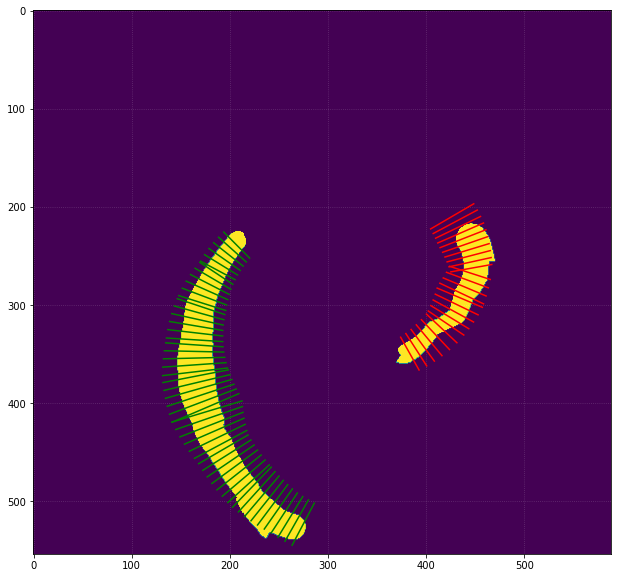

In [5]:
fig = plt.figure(figsize=[20,10])
ax = plt.subplot(111)

ax.imshow(image_data)

ax.grid(color='w', ls=':', alpha=0.2)
plot_original_segments(ax=ax, arm='red')
plot_original_segments(ax=ax, arm='green')


plt.show()

Положение пиков и ширин:

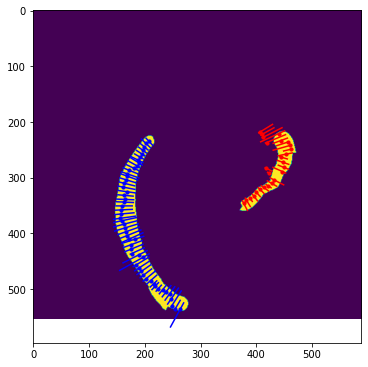

In [6]:
fig = plt.figure(figsize=[20,10])
ax = plt.subplot(131)

# arms_mask = get_arms_mask(**galdict)
# arms_mask = crop_by_radius(data=arms_mask, **galdict)
# plot_2d(ax=ax, data=arms_mask)

ax.imshow(image_data)

locs = np.genfromtxt('./spirals/Sigma_S/borders_red.dat')
for loc in locs:
    cx,cy,leftx,lefty,rightx,righty = loc
    plt.plot([leftx,rightx], [lefty,righty], '-', color='r')
    plt.scatter(cx,cy,10,color='r')
    
locs = np.genfromtxt('./spirals/Sigma_S/borders_green.dat')
for loc in locs:
    cx,cy,leftx,lefty,rightx,righty = loc
    plt.plot([leftx,rightx], [lefty,righty], '-', color='b')
    plt.scatter(cx,cy,10,color='b')
    
plt.show()

Функции чтобы считывать файл среза:

In [7]:
def read_slice_fit_params(path):
    '''parameters of slice fitting'''
    params = []
    with open(path) as inputf:
        lines = inputf.readlines()
        for l in lines[1:6]:
            param = float(l[l.index('=')+1:].replace('\n', ''))
            params.append(param)
    return params

def get_slice_data(path):
    sl_d = np.genfromtxt(path)
    t = sl_d[:, 0]
    y = sl_d[:, 1]
    yerr = sl_d[:, 2]
    return t,y,yerr
    
    
def gaussian_lopsided(dist, params):
    # Unpack params
    amplitude = params[0]
    peak_pos = params[1]
    width_left = params[2]
    width_right = params[3]
    # Compute exponential rise and decay
    flux = np.zeros_like(dist) + amplitude
    left_idx = dist <= peak_pos
    right_idx = dist > peak_pos
    flux[left_idx] *= np.exp(-((dist[left_idx] - peak_pos)**2) / (width_left**2))
    flux[right_idx] *= np.exp(-((dist[right_idx] - peak_pos)**2) / (width_right**2))
    return flux


def get_slice_data_and_fit(slice_path, arm=None, slice_num=None):
    slicef = slice_path + '/slice_{}_{}.dat'.format(arm, slice_num)
    params = read_slice_fit_params(slicef)
    dist, obs, obs_err = get_slice_data(slicef)
    fitted = gaussian_lopsided(dist, params)
    return dist, obs, obs_err, fitted

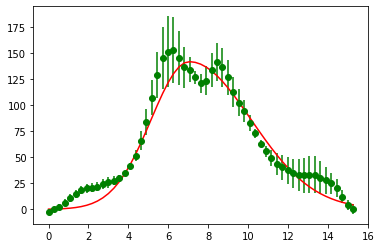

In [8]:
dist, obs, obs_err, fitted = get_slice_data_and_fit('spirals/Sigma_S', arm='green', slice_num='005')
plt.errorbar(dist, obs, yerr=obs_err, color='g', fmt='o')
plt.plot(dist, fitted, '-', color='r')
plt.show()

Итеррирование по срезам (добавление нулей в начале):

In [9]:
arm = 'green'
blue_arm = np.genfromtxt('spirals/Sigma_S/arm_params_{}.dat'.format(arm))
blue_arm_yy = blue_arm[:, 7]

for ii in range(1, len(blue_arm_yy)+1):
    if ii < 10:
        istr = '00'+str(ii)
    elif ii < 100:
        istr = '0'+str(ii)
    else:
        istr = str(ii)

    try:
        print(istr)
        get_slice_data_and_fit('spirals/Sigma_S', arm=arm, slice_num=istr)
    except Exception as e:
        print(e)

001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052


### Разберемся с полуширинами

In [10]:
image_file = get_pkg_data_filename('spirals/arms_mask_projected_corrected_HI.fits')
image_data = fits.getdata(image_file, ext=0)

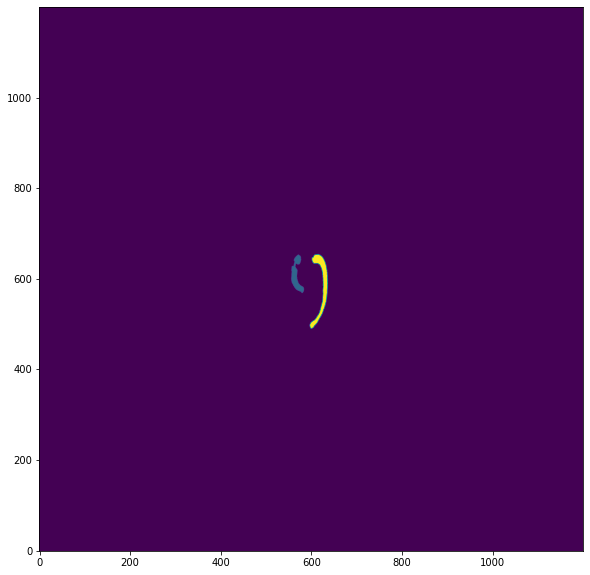

In [11]:
fig = plt.figure(figsize=[20,10])
ax = plt.subplot(111)

ax.imshow(image_data, origin = 'lower')
plt.show()

Сначала "зеленую" спираль

In [12]:
locs = np.genfromtxt('./spirals/projected_smoothed_arm_params_green_HI.dat')
x_peak = []
y_peak = []
x_left = []
y_left = []
x_right = []
y_right = []
for loc in locs:
    x_peak.append(loc[0]+88)
    y_peak.append(loc[1]+88)
    x_left.append(loc[2]+88)
    y_left.append(loc[3]+88)
    x_right.append(loc[4]+88)
    y_right.append(loc[5]+88)

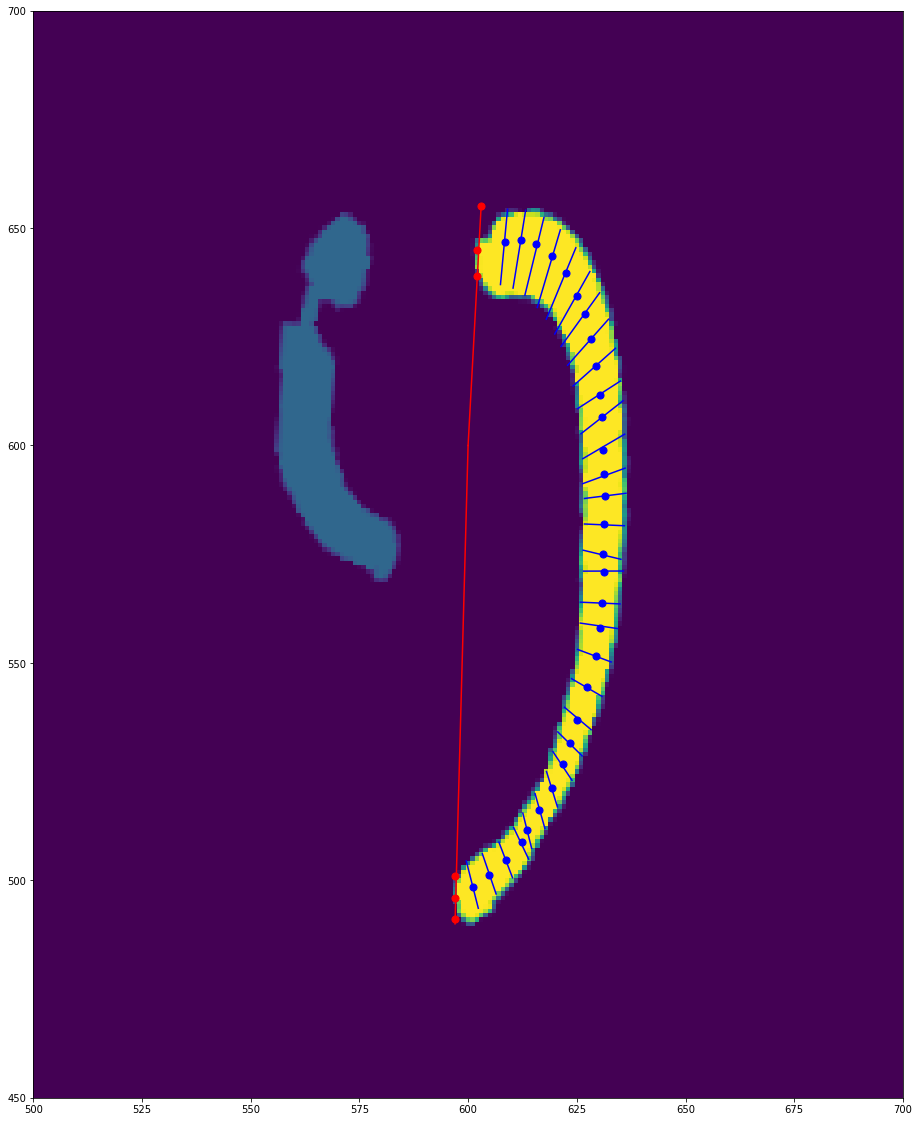

In [13]:
fig = plt.figure(figsize=[20,20])

ax = plt.subplot(111)

ax.imshow(image_data, origin = 'lower')
for i in range(len(x_peak)):
    plt.plot([x_left[i],x_right[i]], [y_left[i],y_right[i]], '-', color='b')
    plt.scatter(x_peak[i],y_peak[i],50,color='b')
    
#подберем границы для интерполяции    
plt.plot([600,603], [600,655], '-', color='r')
plt.scatter(603,655,50,color='r')
plt.scatter(602,645,50,color='r')
plt.scatter(602,639,50,color='r')

plt.plot([600,597], [600,490], '-', color='r')
plt.scatter(597,501,50,color='r')
plt.scatter(597,496,50,color='r')
plt.scatter(597,491,50,color='r')

plt.xlim(500,700)
plt.ylim(450,700)
plt.show()

In [14]:
locs = np.genfromtxt('./spirals/projected_smoothed_arm_params_green_HI.dat')
x_peak = []
y_peak = []
x_left = []
y_left = []
x_right = []
y_right = []

x_peak.append(602.)
y_peak.append(645.)
x_left.append(602.)
y_left.append(638.)
x_right.append(603.)
y_right.append(655.)
    
for loc in locs:
    x_peak.append(loc[0]+88)
    y_peak.append(loc[1]+88)
    x_left.append(loc[2]+88)
    y_left.append(loc[3]+88)
    x_right.append(loc[4]+88)
    y_right.append(loc[5]+88)
    
x_peak.append(597.)
y_peak.append(496.)
x_left.append(597.)
y_left.append(503.)
x_right.append(597.)
y_right.append(491.)
    

In [15]:
#print(y_left)
#print(x_left)
#print(y_peak)
#print(x_peak)
#print(y_right)
#print(x_right)

In [16]:
from scipy.interpolate import interp1d
f_left = interp1d(y_left, x_left, kind = 'linear')
f_left_ = interp1d(x_left[0:6], y_left[0:6], kind = 'linear')
f_center = interp1d(y_peak[2:], x_peak[2:], kind = 'linear')
f_center_ = interp1d(x_peak[0:6], y_peak[0:6], kind = 'linear')
f_right = interp1d(y_right, x_right, kind = 'linear')
f_right_ = interp1d(x_right[0:6], y_right[0:6], kind = 'linear')

In [17]:
Y_center = np.arange(647,495,-1)
Y_left = np.arange(638,502,-1)
Y_right = np.arange(655,490,-1)
X_center = np.arange(602,623,1)
X_left = np.arange(602,608,1)
X_right = np.arange(603,625,1)

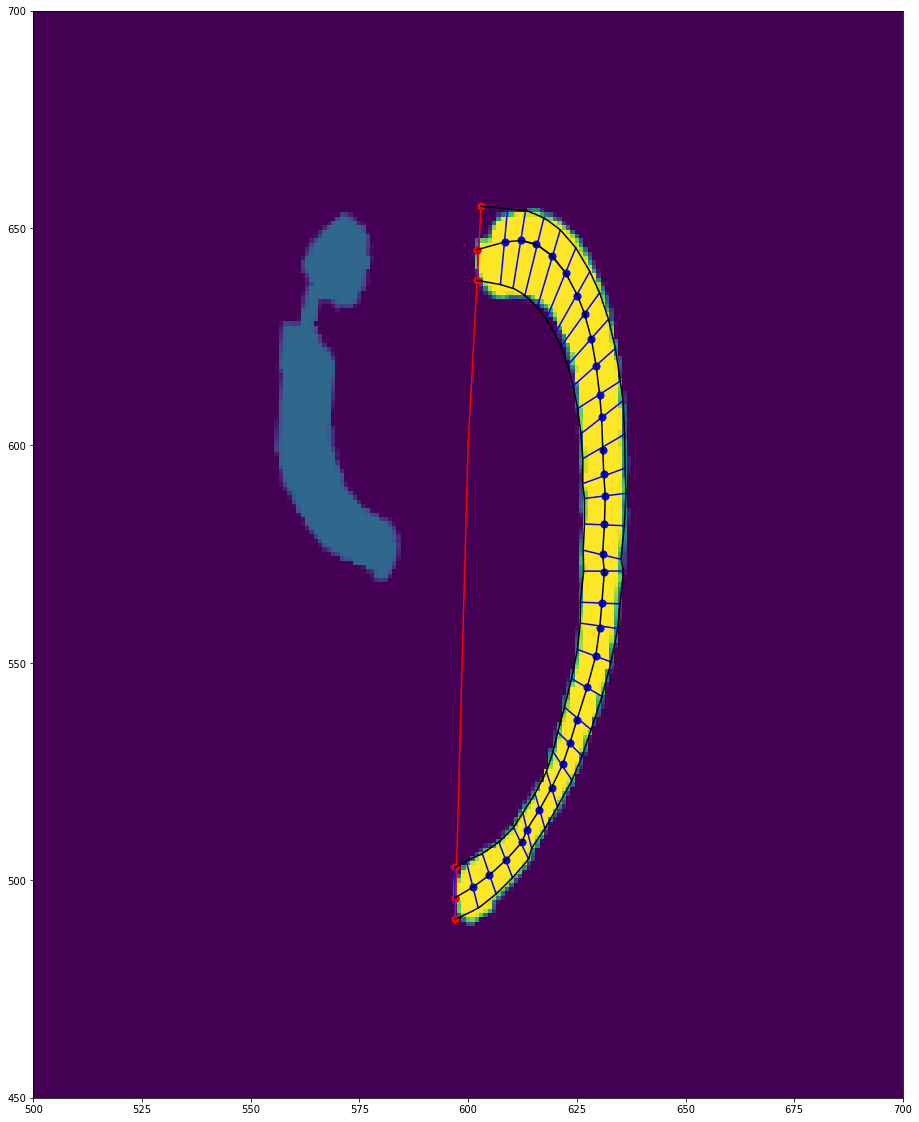

In [18]:
fig = plt.figure(figsize=[20,20])

ax = plt.subplot(111)

ax.imshow(image_data, origin = 'lower')
for i in range(len(x_peak)):
    plt.plot([x_left[i],x_right[i]], [y_left[i],y_right[i]], '-', color='b')
    plt.scatter(x_peak[i],y_peak[i],50,color='b')
    
#подберем границы для интерполяции    
plt.plot([600,603], [600,655], '-', color='r')
plt.scatter(603,655,50,color='r')
plt.scatter(602,645,50,color='r')
plt.scatter(602,638,50,color='r')

plt.plot([600,597], [600,490], '-', color='r')
plt.scatter(597,503,50,color='r')
plt.scatter(597,496,50,color='r')
plt.scatter(597,491,50,color='r')

plt.plot(f_center(Y_center),Y_center, '-', color='black')
plt.plot(X_center,f_center_(X_center), '-', color='black')
plt.plot(f_left(Y_left),Y_left, '-', color='black')
plt.plot(f_right(Y_right),Y_right, '-', color='black')

plt.xlim(500,700)
plt.ylim(450,700)

plt.show()

In [19]:
bounds_and_peaks = np.zeros((1200,1200))

for y in Y_left:
    x = int(f_left(y))
    bounds_and_peaks[y][x] = 1.
for x in X_left:
    y = int(f_left_(x))
    bounds_and_peaks[y][x] = 1.    
    
for y in Y_right:
    x = int(f_right(y))
    bounds_and_peaks[y][x] = 3.
for x in X_right:
    y = int(f_right_(x))
    bounds_and_peaks[y][x] = 3.     
    
for y in Y_center:
    x = int(f_center(y))
    bounds_and_peaks[y][x] = 2. 
for x in X_center:
    y = int(f_center_(x))
    bounds_and_peaks[y][x] = 2. 

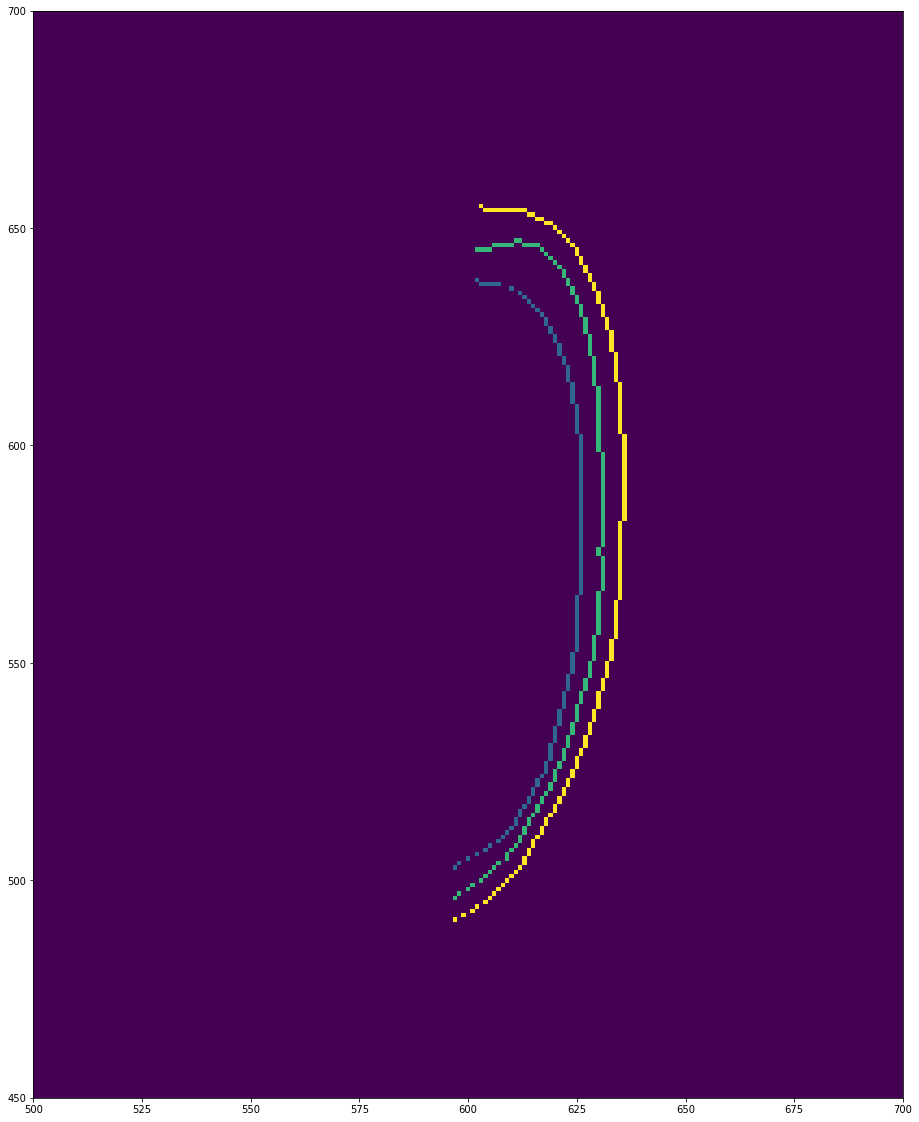

In [20]:
fig = plt.figure(figsize=[20,20])

ax = plt.subplot(111)

ax.imshow(bounds_and_peaks, origin = 'lower')

plt.xlim(500,700)
plt.ylim(450,700)

plt.show()

Теперь для "красной" спирали

In [21]:
locs = np.genfromtxt('./spirals/projected_smoothed_arm_params_red_HI.dat')
x_peak = []
y_peak = []
x_left = []
y_left = []
x_right = []
y_right = []
for loc in locs:
    x_peak.append(loc[0]+88)
    y_peak.append(loc[1]+88)
    x_left.append(loc[2]+88)
    y_left.append(loc[3]+88)
    x_right.append(loc[4]+88)
    y_right.append(loc[5]+88)

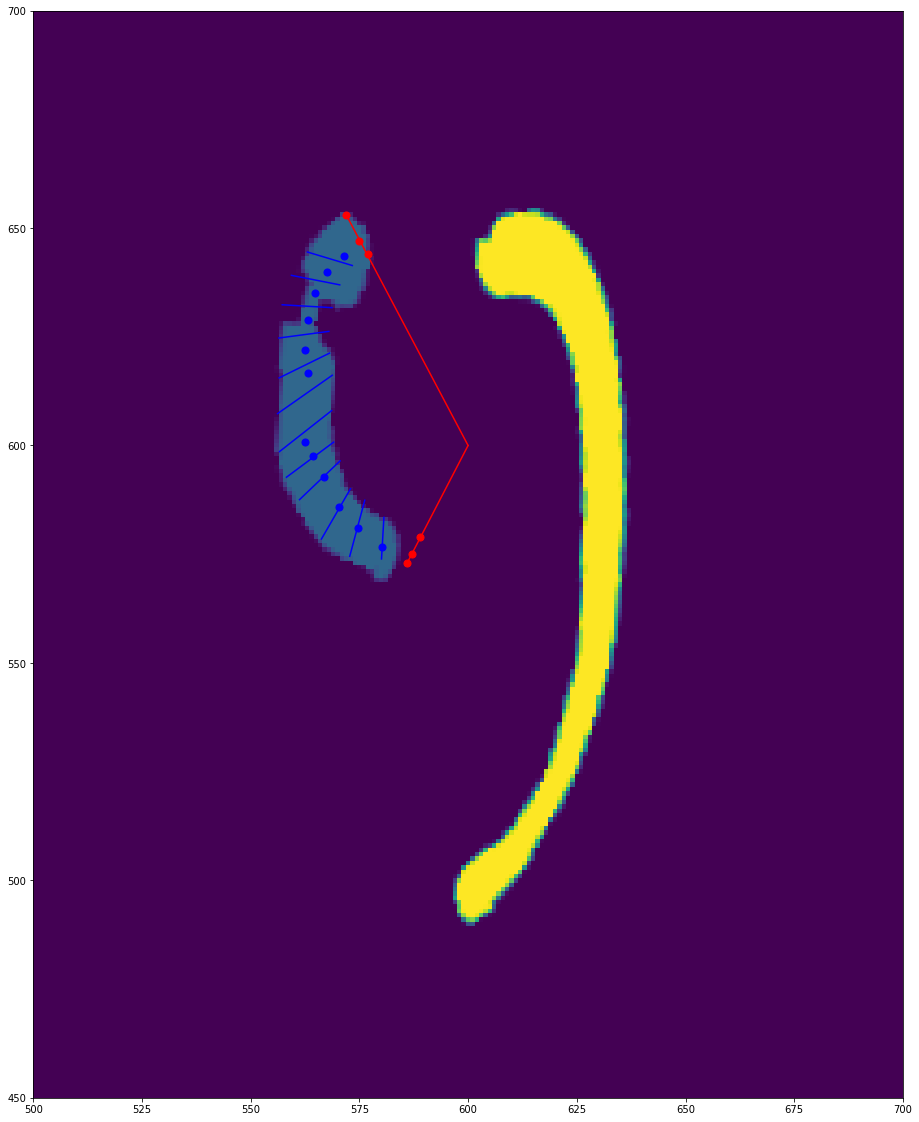

In [22]:
fig = plt.figure(figsize=[20,20])

ax = plt.subplot(111)

ax.imshow(image_data, origin = 'lower')
for i in range(12):
    plt.plot([x_left[i],x_right[i]], [y_left[i],y_right[i]], '-', color='b')
    plt.scatter(x_peak[i],y_peak[i],50,color='b')
    
#подберем границы для интерполяции    
plt.plot([600,572], [600,653], '-', color='r')
plt.scatter(572,653,50,color='r')
plt.scatter(575,647,50,color='r')
plt.scatter(577,644,50,color='r')

plt.plot([600,586], [600,573], '-', color='r')
plt.scatter(586,573,50,color='r')
plt.scatter(587,575,50,color='r')
plt.scatter(589,579,50,color='r')

plt.xlim(500,700)
plt.ylim(450,700)
plt.show()

In [23]:
locs = np.genfromtxt('./spirals/projected_smoothed_arm_params_red_HI.dat')
x_peak = []
y_peak = []
x_left = []
y_left = []
x_right = []
y_right = []

x_peak.append(587.)
y_peak.append(576.)
x_left.append(589.)
y_left.append(579.)
x_right.append(586.)
y_right.append(573.)
    
for loc in locs:
    x_peak.append(loc[0]+88)
    y_peak.append(loc[1]+88)
    x_left.append(loc[2]+88)
    y_left.append(loc[3]+88)
    x_right.append(loc[4]+88)
    y_right.append(loc[5]+88)
    
x_peak.append(575.)
y_peak.append(647.)
x_left.append(577.)
y_left.append(644.)
x_right.append(572.)
y_right.append(653.)    
    

    

In [24]:
#print(y_left)
#print(x_left)
#print(y_peak)
#print(x_peak)
#print(y_right)
#print(x_right)

In [25]:
from scipy.interpolate import interp1d
f_left = interp1d(y_left[:], x_left[:], kind = 'linear')
f_left_ = interp1d(x_left[:5], y_left[:5], kind = 'linear')
f_center = interp1d(y_peak, x_peak, kind = 'linear')
f_center_ = interp1d(x_peak[:5], y_peak[:5], kind = 'linear')
f_right = interp1d(y_right, x_right, kind = 'linear')
f_right_ = interp1d(x_right[:5], y_right[:5], kind = 'linear')

In [26]:
Y_center = np.arange(576,648,1)
Y_left = np.arange(579,644,1)
Y_right = np.arange(573,654,1)
X_center = np.arange(587,569,-1)
X_left = np.arange(589,572,-1)
X_right = np.arange(586,565,-1)

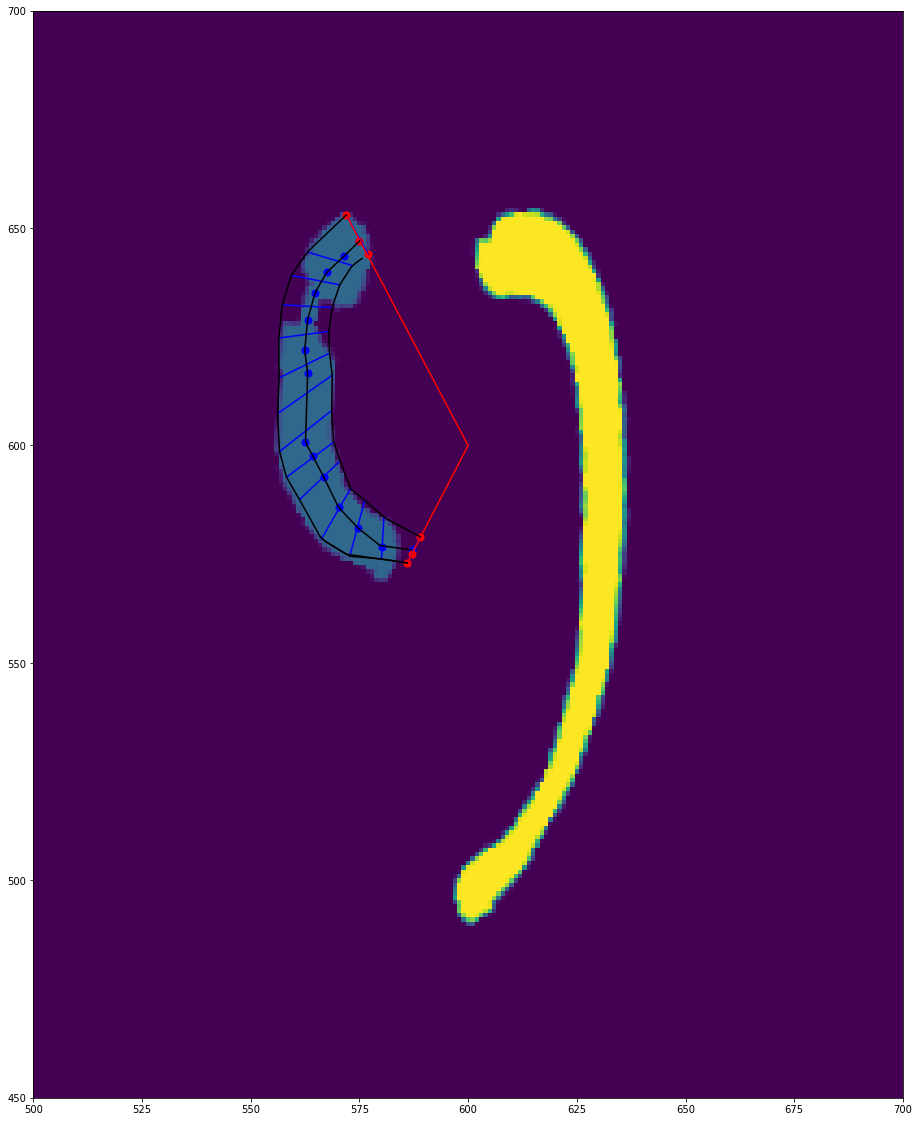

In [28]:
fig = plt.figure(figsize=[20,20])

ax = plt.subplot(111)

ax.imshow(image_data, origin = 'lower')
for i in range(len(x_peak)):
    plt.plot([x_left[i],x_right[i]], [y_left[i],y_right[i]], '-', color='b')
    plt.scatter(x_peak[i],y_peak[i],50,color='b')
    
#подберем границы для интерполяции    
plt.plot([600,572], [600,653], '-', color='r')
plt.scatter(572,653,50,color='r')
plt.scatter(575,647,50,color='r')
plt.scatter(577,644,50,color='r')

plt.plot([600,586], [600,573], '-', color='r')
plt.scatter(586,573,50,color='r')
plt.scatter(587,575,50,color='r')
plt.scatter(589,579,50,color='r')


plt.plot(f_center(Y_center),Y_center, '-', color='black')

plt.plot(f_left(Y_left),Y_left, '-', color='black')
plt.plot(f_right(Y_right),Y_right, '-', color='black')

plt.xlim(500,700)
plt.ylim(450,700)
plt.plot(X_right,f_right_(X_right), '-', color='black')
plt.show()

In [29]:
for y in Y_left:
    x = int(f_left(y))
    bounds_and_peaks[y][x] = 1.
for x in X_left:
    y = int(f_left_(x))
    bounds_and_peaks[y][x] = 1.    
    
for y in Y_right:
    x = int(f_right(y))
    bounds_and_peaks[y][x] = 3.
for x in X_right:
    y = int(f_right_(x))
    bounds_and_peaks[y][x] = 3.     
    
for y in Y_center:
    x = int(f_center(y))
    bounds_and_peaks[y][x] = 2. 
for x in X_center:
    y = int(f_center_(x))
    bounds_and_peaks[y][x] = 2. 

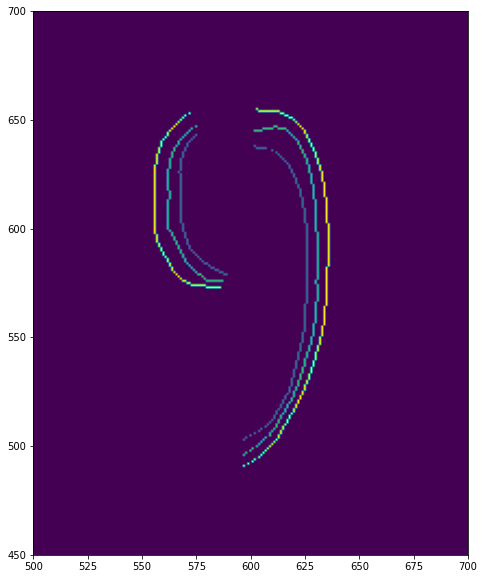

In [30]:
fig = plt.figure(figsize=[10,10])

ax = plt.subplot(111)

ax.imshow(bounds_and_peaks, origin = 'lower')

plt.xlim(500,700)
plt.ylim(450,700)

plt.show()

Теперь обрежем эти данные как нам нужно

In [31]:
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel

In [32]:
bounds_and_peaks_ = np.zeros((1024,1024))
bounds_and_peaks_ = bounds_and_peaks[76:,76:]

data = fits.getdata('./data/NGC_3627_NA_MOM0_THINGS.FITS')
data = np.squeeze(data)
data_WCS = WCS('./data/NGC_3627_NA_MOM0_THINGS.FITS', naxis = 2)
cposition= SkyCoord('170.06205 12.9917', frame='icrs', unit='deg', equinox='J2000.0')

size = [380,160] 
size_ = u.Quantity(size, u.arcsec)

data = Cutout2D(data, cposition, size_, wcs=data_WCS, mode='partial', fill_value=0.)    
bounds_and_peaks_= Cutout2D(bounds_and_peaks_, cposition, size_, wcs=data_WCS, mode='partial', fill_value=0.)
#image_data = np.squeeze(image_data)

# теперь делаем их нужной размерности
shape = [190,80]
first_data = fits.getdata('./data/NGC3627_map_ha_corr.fits')
first_data = np.squeeze(first_data)
first_WCS = WCS('./data/NGC3627_map_ha_corr.fits', naxis = 2)
first_data = Cutout2D(first_data, cposition, size_, wcs=first_WCS, mode='partial', fill_value=0.)

print(first_data.shape)
X, Y = np.meshgrid(np.arange(0, shape[1], 1), np.arange(0, shape[0], 1))
sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), first_data.wcs).reshape((shape[0], shape[1]))
    
grid_pixs = []
new_data = []
for scoord in sgrid.ravel():
    spix = skycoord_to_pixel(scoord, data.wcs)
    grid_pixs.append(spix)
    new_data.append(bounds_and_peaks_.data[int(spix[1]),int(spix[0])])
    
new_data = np.array(new_data).reshape(190,80)

(190, 80)


In [81]:
Sigma_HI = np.load('./data/Sigma_HI.npy')
Sigma_H2 = np.load('./data/Sigma_H2.npy')
dist_kpc = np.load('./data/dist_kpc_corr.npy')

<ipython-input-34-c61c968a4b3a>:6: UserWarning: The following kwargs were not used by contour: 'aspect'
  CS = plt.contour(X, Y, Sigma_HI, levels=[3.2,], aspect='black')
<ipython-input-34-c61c968a4b3a>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  quadmesh = plt.pcolormesh(X, Y, Sigma_HI, cmap='magma')
<ipython-input-34-c61c968a4b3a>:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()
  quadmesh.cmap.set_under('white')
<ipython-input-34-c61c968a4b3a>:15: Matplotli

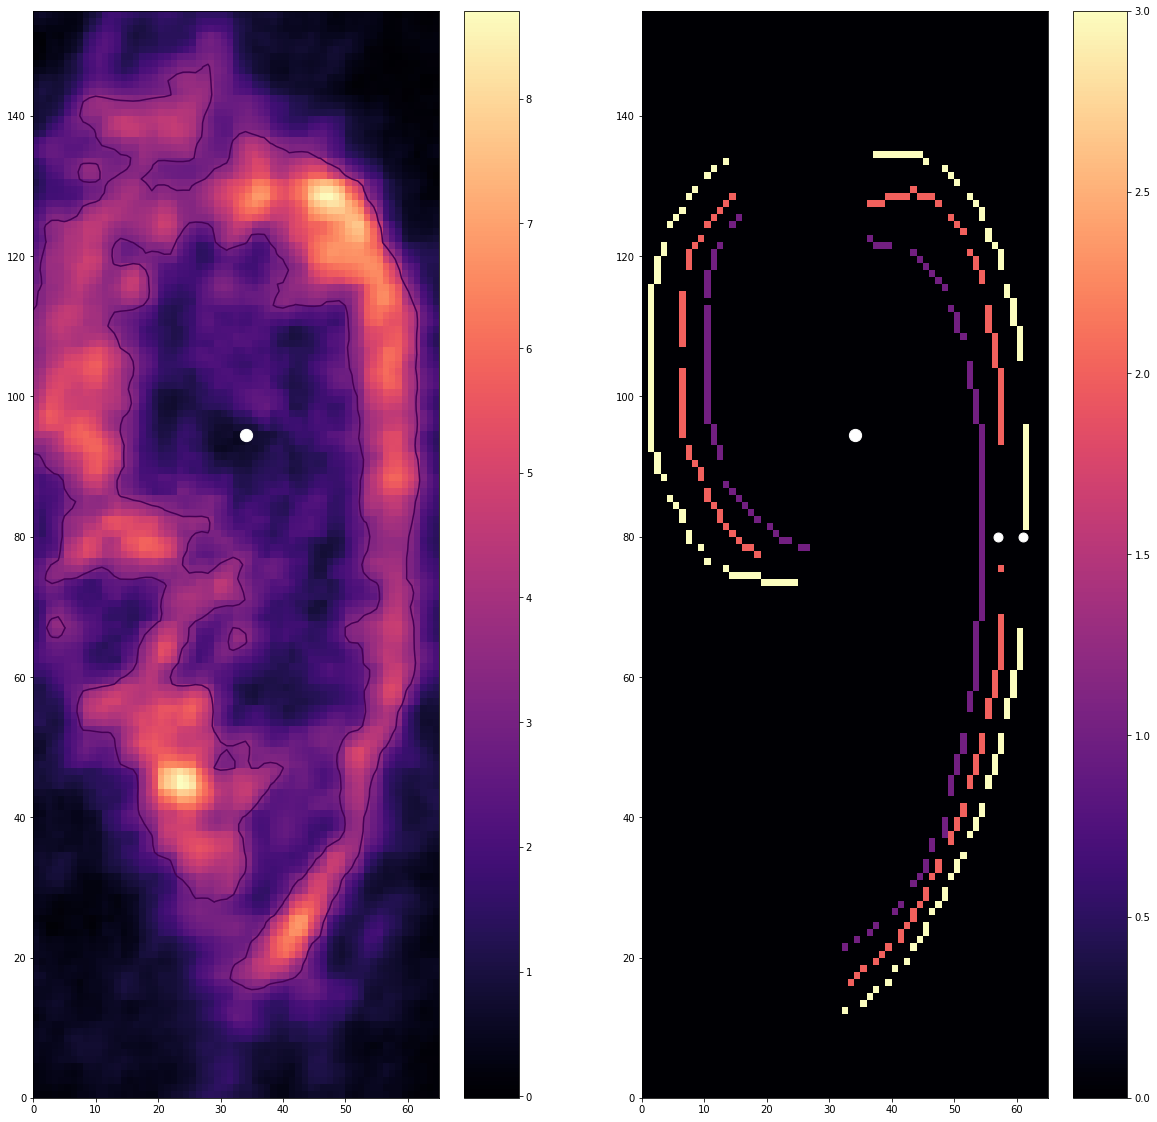

In [34]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
X1,Y1 = np.meshgrid(np.arange(0.,80,1), np.arange(0.,190,1))

fig = plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, Sigma_HI, levels=[3.2,], aspect='black')
quadmesh = plt.pcolormesh(X, Y, Sigma_HI, cmap='magma')
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )

plt.subplot(1,2,2)
new_data_ = new_data[10:-24,14:]
#CS = plt.contour(X, Y, phi, levels=[32., 154.], color='white')
quadmesh = plt.pcolormesh(X, Y, new_data_, cmap='magma')
#quadmesh.set_clim(vmin=0., vmax=7000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )
plt.scatter(57 ,80,[80.], color='white' )
plt.scatter(61 ,80,[80.], color='white' )

In [35]:
#заполнимм пропуски
bounds_and_peaks_cut = new_data[10:-24,14:]
bounds_and_peaks_cut[65:95,57] = 2.
bounds_and_peaks_cut[65:85,61] = 3.
bounds_and_peaks_cut[104:109,51] = 1.
bounds_and_peaks_cut[88:92,12] = 1.
bounds_and_peaks_cut[97:106,61] = 3.
bounds_and_peaks_cut[77,18:23] = 2.
bounds_and_peaks_cut[76,23:27] = 2.
bounds_and_peaks_cut[121,38:42] = 1.
bounds_and_peaks_cut[121,38:42] = 1.
bounds_and_peaks_cut[103:108,6] = 2.

In [36]:
phi = np.load('./data/phi.npy')

<ipython-input-54-cd22b65dbb5b>:3: UserWarning: The following kwargs were not used by contour: 'color'
  CS = plt.contour(X, Y, phi, levels=np.linspace(34,163.,24), color='white')
<ipython-input-54-cd22b65dbb5b>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  quadmesh = plt.pcolormesh(X, Y,bounds_and_peaks_cut, cmap='magma')
<ipython-input-54-cd22b65dbb5b>:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()
  quadmesh.cmap.set_under('white')


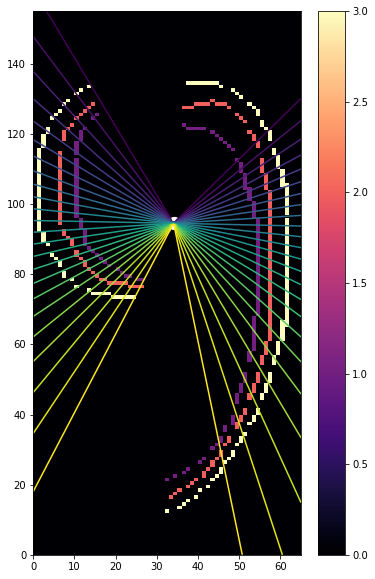

In [54]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[6,10])
CS = plt.contour(X, Y, phi, levels=np.linspace(34,163.,24), color='white')
#CS = plt.contour(X, Y, phi, levels=np.linspace(130,175.,15), color='white')
quadmesh = plt.pcolormesh(X, Y,bounds_and_peaks_cut, cmap='magma')

#quadmesh.set_clim(vmin=0., vmax=7000.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )


In [38]:
dist_peak = np.zeros(dist_kpc.shape)
dist_left = np.zeros(dist_kpc.shape)
dist_right = np.zeros(dist_kpc.shape)

for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
        if (bounds_and_peaks_cut[i][j] == 1.):
            dist_left[i][j] = dist_kpc[i][j]
         
        elif (bounds_and_peaks_cut[i][j] == 2.):
            dist_peak[i][j] = dist_kpc[i][j]
            
        elif (bounds_and_peaks_cut[i][j] == 3.):
            dist_right[i][j] = dist_kpc[i][j]    

In [39]:
mask_gas =  np.load('./data/mask_gas.npy')

In [62]:
width_green = np.zeros(dist_kpc.shape)
phi_bounders = np.linspace(0,130.,23)

for k in range(22):
    d_l = []
    d_r = []
    d_c = []
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
        
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (dist_left[i][j]!=0) & (j>30):
                d_l.append(dist_left[i][j])
                
            elif(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (dist_right[i][j]!=0) & (j>30):
                d_r.append(dist_right[i][j])
                
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (dist_peak[i][j]!=0) & (j>30):
                d_c.append(dist_peak[i][j])    
    
    width = ((np.mean(d_c)-np.mean(d_l))+(np.mean(d_r)-np.mean(d_c)))/2
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (mask_gas[i][j]>2.5):
                
                width_green[i][j] = width
                
phi_bounders1 = np.linspace(130.,175.,16)
                
for k in range(15):
    d_l = []
    d_r = []
    d_c = []
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
        
            if(phi_bounders1[k]<=phi[i][j]<=phi_bounders1[k+1]) & (dist_left[i][j]!=0) & (j>30):
                d_l.append(dist_left[i][j])
                
            elif(phi_bounders1[k]<=phi[i][j]<=phi_bounders1[k+1]) & (dist_right[i][j]!=0) & (j>30):
                d_r.append(dist_right[i][j])
                
            if(phi_bounders1[k]<=phi[i][j]<=phi_bounders1[k+1]) & (dist_peak[i][j]!=0) & (j>30):
                d_c.append(dist_peak[i][j])    
    
    width = ((np.mean(d_c)-np.mean(d_l))+(np.mean(d_r)-np.mean(d_c)))/2
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if(phi_bounders1[k]<=phi[i][j]<=phi_bounders1[k+1]) & (mask_gas[i][j]>2.5):
                
                width_green[i][j] = width                

In [72]:
width_red = np.zeros(dist_kpc.shape)
phi_bounders = np.linspace(34,163.,23)

for k in range(22):
    d_l = []
    d_r = []
    d_c = []
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
        
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (dist_left[i][j]!=0) & (j<30):
                d_l.append(dist_left[i][j])
                
            elif(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (dist_right[i][j]!=0) & (j<30):
                d_r.append(dist_right[i][j])
                
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (dist_peak[i][j]!=0) & (j<30):
                d_c.append(dist_peak[i][j])    
    
    width = ((np.mean(d_c)-np.mean(d_l))+(np.mean(d_r)-np.mean(d_c)))/2
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (mask_gas[i][j]==1.):
                
                width_red[i][j] = width
                


<ipython-input-73-37cf56ee3d18>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  quadmesh = plt.pcolormesh(X, Y,width_green, cmap='magma')
<ipython-input-73-37cf56ee3d18>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  quadmesh = plt.pcolormesh(X, Y,width_red, cmap='magma')


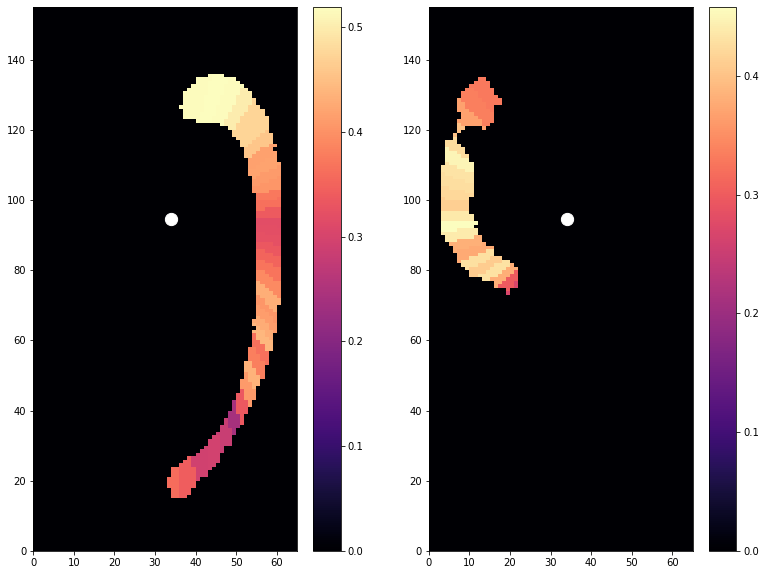

In [73]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[13,10])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y,width_green, cmap='magma')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )

plt.subplot(1,2,2)
quadmesh = plt.pcolormesh(X, Y,width_red, cmap='magma')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )


In [75]:
np.save('./data/width_red.npy',width_red)
np.save('./data/width_green.npy',width_green)

Теперь сделаем массив из пиков плотности

In [76]:
Sigma_HI_peak = np.zeros(dist_kpc.shape)
#заполняем Red spiral 
phi_bounders = np.linspace(34,163.,23)
for k in range(22):
    gas_peak = []
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if (phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) &(bounds_and_peaks_cut[i][j] == 2.) & (j<30):
                gas_peak.append(Sigma_HI[i][j])
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (mask_gas[i][j]==1):
                
                Sigma_HI_peak[i][j] = np.max(gas_peak) 

#заполняем green spiral 
phi_bounders = np.linspace(130.,175.,16)
for k in range(15):
    gas_peak = []
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if (phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (bounds_and_peaks_cut[i][j] == 2.) & (j>30):
                gas_peak.append(Sigma_HI[i][j])
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (mask_gas[i][j]>2.5):
                
                Sigma_HI_peak[i][j] = np.max(gas_peak)
                
phi_bounders = np.linspace(0,130.,23)
for k in range(22):
    gas_peak = []
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if (phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (bounds_and_peaks_cut[i][j] == 2.) & (j>30):
                gas_peak.append(Sigma_HI[i][j])
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (mask_gas[i][j]>2.5):
                
                Sigma_HI_peak[i][j] = np.max(gas_peak)                 

<ipython-input-77-055214f2fdff>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  quadmesh = plt.pcolormesh(X, Y,Sigma_HI_peak, cmap='magma')


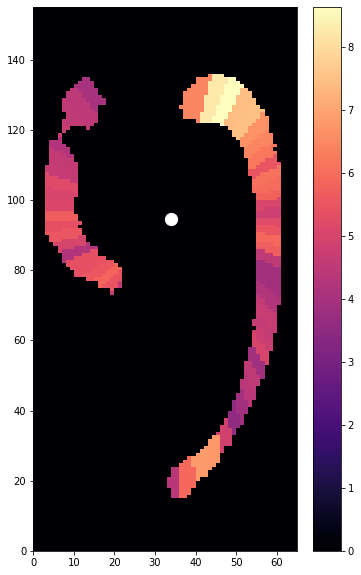

In [77]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[13,10])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y,Sigma_HI_peak, cmap='magma')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )

In [79]:
np.save('./data/Sigma_HI_peak.npy',Sigma_HI_peak)

In [83]:
Sigma_H2_peak = np.zeros(dist_kpc.shape)
#заполняем Red spiral 
phi_bounders = np.linspace(34,163.,23)
for k in range(22):
    gas_peak = []
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if (phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) &(bounds_and_peaks_cut[i][j] == 2.) & (j<30):
                gas_peak.append(Sigma_H2[i][j])
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (mask_gas[i][j]==1):
                
                Sigma_H2_peak[i][j] = np.max(gas_peak) 

#заполняем green spiral 
phi_bounders = np.linspace(130.,175.,16)
for k in range(15):
    gas_peak = []
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if (phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (bounds_and_peaks_cut[i][j] == 2.) & (j>30):
                gas_peak.append(Sigma_H2[i][j])
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (mask_gas[i][j]>2.5):
                
                Sigma_H2_peak[i][j] = np.max(gas_peak)
                
phi_bounders = np.linspace(0,130.,23)
for k in range(22):
    gas_peak = []
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if (phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (bounds_and_peaks_cut[i][j] == 2.) & (j>30):
                gas_peak.append(Sigma_H2[i][j])
    
    for i, row in enumerate(dist_kpc):
        for j, col in enumerate(dist_kpc[0]):
            
            if(phi_bounders[k]<=phi[i][j]<=phi_bounders[k+1]) & (mask_gas[i][j]>2.5):
                
                Sigma_H2_peak[i][j] = np.max(gas_peak)                 

<ipython-input-84-67582938110d>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  quadmesh = plt.pcolormesh(X, Y,Sigma_H2_peak, cmap='magma')


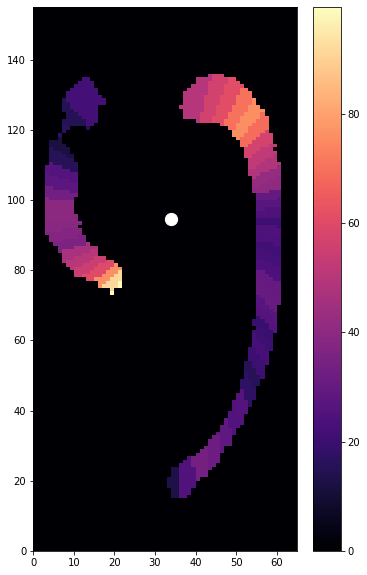

In [84]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[13,10])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y,Sigma_H2_peak, cmap='magma')
plt.colorbar()
plt.scatter(34.06509169 ,94.54027961,[150.], color='white' )

In [85]:
np.save('./data/Sigma_H2_peak.npy',Sigma_H2_peak)